<a href="https://colab.research.google.com/github/johnpsom/LSTM-model/blob/main/LSTM_model_for_Ticker_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [74]:
import tensorflow as tf
import keras
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
# Check TensorFlow version
print("TensorFlow Version: ", tf.__version__)

TensorFlow Version:  2.15.0


In [75]:
# Define the ticker symbol
tickerSymbol = 'TSLA' # other symbols NVDA, TSLA, AAPL, BTC-USD, ETH-USD

# Get data on this ticker
tickerData = yf.Ticker(tickerSymbol)

# Get the historical prices for this ticker
tickerDf = tickerData.history(period='1d', start='2020-1-1', end='2024-4-1')

# See your data
tickerDf

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2020-01-02 00:00:00-05:00,28.299999,28.713333,28.114000,28.684000,142981500,0.0,0.0
2020-01-03 00:00:00-05:00,29.366667,30.266666,29.128000,29.534000,266677500,0.0,0.0
2020-01-06 00:00:00-05:00,29.364668,30.104000,29.333332,30.102667,151995000,0.0,0.0
2020-01-07 00:00:00-05:00,30.760000,31.441999,30.224001,31.270666,268231500,0.0,0.0
2020-01-08 00:00:00-05:00,31.580000,33.232666,31.215334,32.809334,467164500,0.0,0.0
...,...,...,...,...,...,...,...
2024-03-22 00:00:00-04:00,166.690002,171.199997,166.300003,170.830002,75454700,0.0,0.0
2024-03-25 00:00:00-04:00,168.759995,175.240005,168.729996,172.630005,74228600,0.0,0.0
2024-03-26 00:00:00-04:00,178.580002,184.250000,177.380005,177.669998,113186200,0.0,0.0


In [76]:
# Display the last few rows of the dataframe
tickerDf.tail()
# Checking for missing values
tickerDf.isnull().sum()

# Filling missing values, if any
tickerDf.fillna(method='ffill', inplace=True)
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
ticker_data_scaled = scaler.fit_transform(tickerDf['Close'].values.reshape(-1,1))

In [77]:
ticker_data_scaled



array([[0.01192745],
       [0.01413016],
       [0.01560381],
       ...,
       [0.39801289],
       [0.40361037],
       [0.39314101]])

In [78]:
X = []
y = []

for i in range(30, len(ticker_data_scaled)):
    X.append(ticker_data_scaled[i-30:i, 0])
    y.append(ticker_data_scaled[i, 0])

train_size = int(len(X) * 0.8)
test_size = len(X) - train_size

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [79]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, AdditiveAttention, Permute, Reshape, Multiply
from keras.layers import BatchNormalization

model = Sequential()

# Adding LSTM layer with return_sequences=True
model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], 1)))
# Adding Dropout and Batch Normalization
model.add(Dropout(0.2))
model.add(BatchNormalization())
# Adding 2nd LSTM layer with return_sequences=True
model.add(LSTM(units=50, return_sequences=True))

# Adding self-attention mechanism
# The attention mechanism
attention = AdditiveAttention(name='attention_weight')
# Permute and reshape for compatibility
model.add(Permute((2, 1)))
model.add(Reshape((-1, X_train.shape[1])))
attention_result = attention([model.output, model.output])
multiply_layer = Multiply()([model.output, attention_result])
# Return to original shape
model.add(Permute((2, 1)))
model.add(Reshape((-1, 50)))

# Adding a Flatten layer before the final Dense layer
model.add(tf.keras.layers.Flatten())

# Final Dense layer
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

# Train the model
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(X_train, y_train, epochs=60, batch_size=25, validation_split=0.2, callbacks=[early_stopping])

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 30, 100)           40800     
                                                                 
 dropout_5 (Dropout)         (None, 30, 100)           0         
                                                                 
 batch_normalization_5 (Bat  (None, 30, 100)           400       
 chNormalization)                                                
                                                                 
 lstm_11 (LSTM)              (None, 30, 50)            30200     
                                                                 
 permute_10 (Permute)        (None, 50, 30)            0         
                                                                 
 reshape_10 (Reshape)        (None, 50, 30)            0         
                                                      

In [80]:
# Convert X_test and y_test to Numpy arrays if they are not already
X_test = np.array(X_test)
y_test = np.array(y_test)

# Ensure X_test is reshaped similarly to how X_train was reshaped
# This depends on how you preprocessed the training data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Now evaluate the model on the test data
test_loss = model.evaluate(X_test, y_test)
print("Test Loss: ", test_loss)

7/7 [==============================] - 0s 15ms/step - loss: 0.0026
Test Loss:  0.0026159228291362524


In [81]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Making predictions
y_pred = model.predict(X_test)

# Calculating MAE and RMSE
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print("Mean Absolute Error: ", mae)
print("Root Mean Square Error: ", rmse)

7/7 [==============================] - 1s 14ms/step
Mean Absolute Error:  0.044483318528830466
Root Mean Square Error:  0.05114609357889646


In [82]:
# Fetch the latest 30 days of ticker data
data = yf.download(tickerSymbol, period='30d', interval='1d')
data
# Select 'Close' price and scale it
closing_prices = data['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(closing_prices)

# Predict the next 5 days iteratively
predicted_prices = []
current_batch = scaled_data[-30:].reshape(1, 30, 1)  # Most recent 30 days

for i in range(5):  # Predicting 5 days
    # Get the prediction (next day)
    next_prediction = model.predict(current_batch)

    # Reshape the prediction to fit the batch dimension
    next_prediction_reshaped = next_prediction.reshape(1, 1, 1)

    # Append the prediction to the batch used for predicting
    current_batch = np.append(current_batch[:, 1:, :], next_prediction_reshaped, axis=1)

    # Inverse transform the prediction to the original price scale
    predicted_prices.append(scaler.inverse_transform(next_prediction)[0, 0])

print("Predicted Ticker Prices for the next 4 days: ", predicted_prices)

[*********************100%%**********************]  1 of 1 completed

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 29ms/step
Predicted Ticker Prices for the next 4 days:  [170.64777, 171.83563, 172.4096, 172.6573, 172.43134]


In [83]:
data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-04-08,169.339996,174.500000,167.789993,172.979996,172.979996,104423300
2024-04-09,172.910004,179.220001,171.919998,176.880005,176.880005,103232700
2024-04-10,173.039993,174.929993,170.009995,171.759995,171.759995,84532400
2024-04-11,172.550003,175.880005,168.509995,174.600006,174.600006,94516000
2024-04-12,172.339996,173.809998,170.360001,171.050003,171.050003,64506600


DatetimeIndex(['2024-04-13', '2024-04-14', '2024-04-15', '2024-04-16', '2024-04-17'], dtype='datetime64[ns]', freq='D')


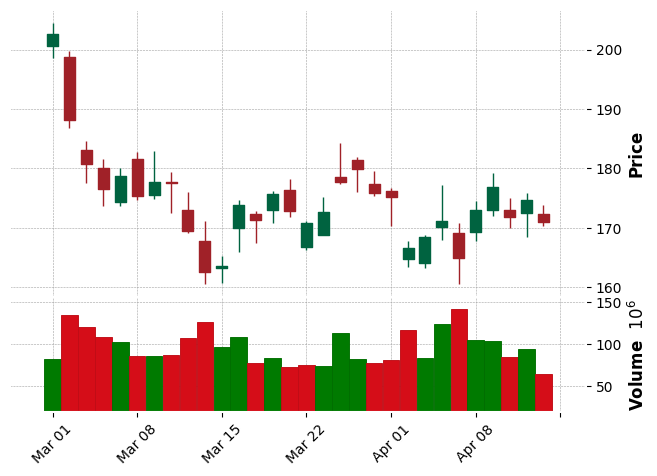

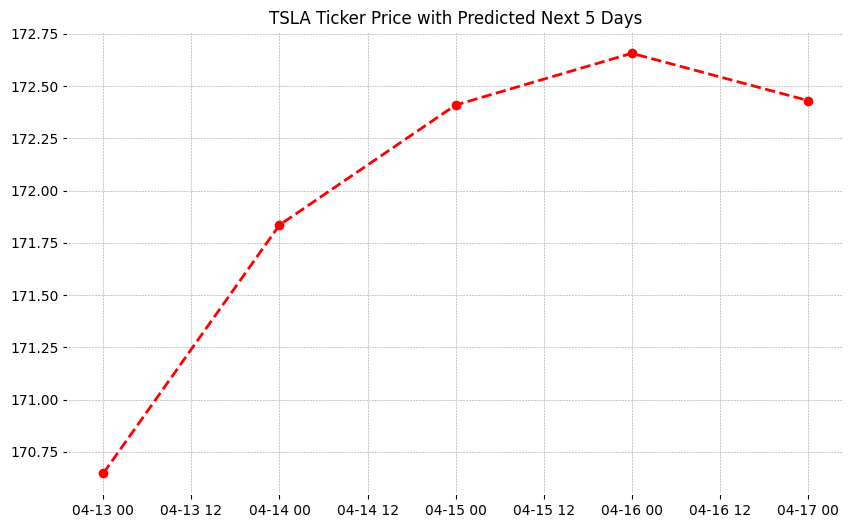

In [84]:
import pandas as pd
import mplfinance as mpf
import matplotlib.dates as mpl_dates
import matplotlib.pyplot as plt

# Assuming 'data' is your DataFrame with the fetched AAPL stock data
# Make sure it contains Open, High, Low, Close, and Volume columns

# Creating a list of dates for the predictions
last_date = data.index[-1]
next_day = last_date + pd.Timedelta(days=1)
prediction_dates = pd.date_range(start=next_day, periods=5)

print(prediction_dates)
# Assuming 'predicted_prices' is your list of predicted prices for the next 4 days
predictions_df = pd.DataFrame(index=prediction_dates, data=predicted_prices, columns=['Close'])

# Plotting the actual data with mplfinance
mpf.plot(data, type='candle', style='charles', volume=True)

# Overlaying the predicted data
plt.figure(figsize=(10,6))
plt.plot(predictions_df.index, predictions_df['Close'], linestyle='dashed', marker='o', color='red')

plt.title(f"{tickerSymbol} Ticker Price with Predicted Next 5 Days")
plt.show()

[*********************100%%**********************]  1 of 1 completed

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 27ms/step


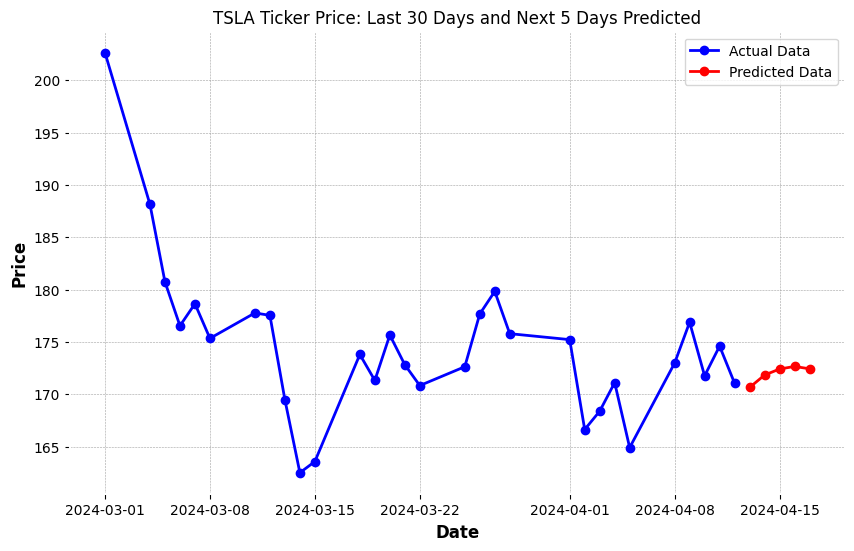

In [85]:
import pandas as pd
import mplfinance as mpf
import matplotlib.dates as mpl_dates
import matplotlib.pyplot as plt

# Fetch the latest 30 days of stock data
data = yf.download(tickerSymbol, period='35d', interval='1d') # Fetch  35 days to display last 30 days in the chart

# Select 'Close' price and scale it
closing_prices = data['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(closing_prices)

# Predict the next 5 days iteratively
predicted_prices = []
current_batch = scaled_data[-30:].reshape(1, 30, 1)  # Most recent 30 days

for i in range(5):  # Predicting 5 days
    next_prediction = model.predict(current_batch)
    next_prediction_reshaped = next_prediction.reshape(1, 1, 1)
    current_batch = np.append(current_batch[:, 1:, :], next_prediction_reshaped, axis=1)
    predicted_prices.append(scaler.inverse_transform(next_prediction)[0, 0])

# Creating a list of dates for the predictions
last_date = data.index[-1]
next_day = last_date + pd.Timedelta(days=1)
prediction_dates = pd.date_range(start=next_day, periods=5)

# Adding predictions to the DataFrame
predicted_data = pd.DataFrame(index=prediction_dates, data=predicted_prices, columns=['Close'])

# Combining both actual and predicted data
combined_data = pd.concat([data['Close'], predicted_data['Close']])
combined_data = combined_data[-35:] # Last 30 days of actual data + 5 days of predictions

# Plotting the actual data
plt.figure(figsize=(10,6))
plt.plot(data.index[-30:], data['Close'][-30:], linestyle='-', marker='o', color='blue', label='Actual Data')

# Plotting the predicted data
plt.plot(prediction_dates, predicted_prices, linestyle='-', marker='o', color='red', label='Predicted Data')

plt.title(f"{tickerSymbol} Ticker Price: Last 30 Days and Next 5 Days Predicted")
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()